In [26]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [2]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [3]:
from cohlib.alg.em_sgc import construct_Gamma_full_real
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
def get_alpha_data(alpha, link, init_type, optim_type, scaling_factor=1, k=0, track=None,
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2
):
    fs = 1000
    delta = 1/fs
    seed = 8
    print()


    alpha=float(alpha)

    sample_length = win
    em_iters = emiter

    data_path = f'saved/synthetic_data/simple_latent_deltarelu_fixed_gamma_{K}_{L}_{sample_length}'
    data_load = pickle_open(data_path)
    latent = data_load['latent']
    Gamma = latent['Gamma']
    zs = latent['zs']
    xs = latent['xs']




    # obs = data_load['observed']
    alphas = np.array([alpha for k in range(K)])

    lams = cif_alpha_relu(alphas, xs)
    spikes = sample_spikes_from_xs(lams, C, delta=1/fs, obs_model='poisson')
    Gamma_zest = Gamma_est_from_zs(zs)



    spikes_mc = spikes.mean(1)
    # ft_spikes = rfft(spikes_mc*(fs/(2*np.pi)), axis=2, norm='backward')
    ft_spikes = rfft(spikes_mc, axis=2, norm='backward')
    S_naive = (ft_spikes * ft_spikes.conj()).mean((0)).real
    S_naive = S_naive[k,1:51]

    ft_spikes0 = ft_spikes[:,0,1:]
    ft_spikes1 = ft_spikes[:,1,1:]

    model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'

    model_load = pickle_open(model_path)
    num_J_vars = int(model_load['Gamma'].shape[0]*2)
    Gamma_init = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)

    S_true = Gamma[:50,k,k].real
    S_oracle = Gamma_zest[:50,k,k].real
    S_init = Gamma_init[:50,k,k].real

    S_true = S_true*scaling_factor
    S_oracle = S_oracle*scaling_factor
    S_init = S_init*scaling_factor

    coh_naive = estimate_coherence(ft_spikes0, ft_spikes1)
    coh_naive = coh_naive[:50]
    coh_true = thr_coherence(Gamma[:50,:,:])
    coh_oracle = thr_coherence(Gamma_zest[:50,:,:])
    coh_init = thr_coherence(Gamma_init[:50,:,:])



    if track is not None:
        S_model = []
        coh_model = []

        for e in range(track[0], track[1]):
            Gamma_est_itr = model_load['track'][0][e]['gamma']
            S_model_itr = Gamma_est_itr[:50,k,k].real
            S_model_itr = S_model_itr*scaling_factor
            coh_model_itr = thr_coherence(Gamma_est_itr[:50,:,:])

            S_model.append(S_model_itr)
            coh_model.append(coh_model_itr)

    else:
        Gamma_est = model_load['Gamma']
        S_model = Gamma_est[:50,k,k].real
        S_model = S_model*scaling_factor
        coh_model = thr_coherence(Gamma_est[:50,:,:])

    S_dict = dict(true=S_true, oracle=S_oracle, model=S_model, naive=S_naive, init=S_init)
    coh_dict = dict(true=coh_true, oracle=coh_oracle, model=coh_model, naive=coh_naive, init=coh_init)

    return dict(coh=coh_dict, S=S_dict, spikes=spikes, lams=lams)



In [4]:
def plot_S(alpha_dict, ax, logS=False):
    S_dict = alpha_dict['S']

    S_true = S_dict['true'][:50]
    S_oracle = S_dict['oracle'][:50]
    S_init = S_dict['init'][:50]
    S_naive = S_dict['naive'][:50]

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)

    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.plot(S_true, color='k', label='true', linewidth=3)
    ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    ax.plot(S_oracle, color='tab:green', label='direct')
    ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = S_dict['model']
        if logS is True:
            S_model = 10*np.log10(S_model)
        ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = S_dict['model']
        S_model_list = S_model_list[:track_show]
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            ax.plot(S_model_itr, color=c, linewidth=3, alpha=0.8)
        ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

    if logS is True:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([1e4,1e8])

In [5]:
# link = "relu"
# init_type = "flat"
# optim_type = "BFGS"

# track = np.array([0,25])
# track += 0
# track=None

# # alphas = [200, 350, 400, 500, 600]
# alphas = [200, 400, 600, 800, 1000]
# # alphas = [6.0]
# alpha_fits = []
# for alpha in alphas:
#     alpha = float(alpha)
#     print(alpha)
#     alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, track=track)
#     alpha_fits.append(alpha_dict)

In [6]:
# fig, ax = plt.subplots(1,5,figsize=(18,3))
# for a, alpha in enumerate(alphas):
#     alpha_dict = alpha_fits[a]
#     plot_S(alpha_dict,  ax[a], True)
#     ax[a].set_ylim([20,40])
# plt.tight_layout()

In [7]:
# fig, ax = plt.subplots(1,5,figsize=(18,3))
# for a, alpha in enumerate(alphas):
#     alpha_dict = alpha_fits[a]
#     lams = alpha_dict['lams']
#     L = lams.shape[0]
#     for l in range(L):
#         ax[a].plot(lams[l,0,:])
#     # ax[a].set_ylim([-65,-5])
# plt.tight_layout()

In [27]:
def plot_res_S(link, init_type, optim_type, alpha, logS, track, k=0, scaling_factor=1, ax=None, title=True,
                    win=1000,
                    L=50,
                    C=1,
                    emiter=20,
                    K=2
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5,3))
    i = 0

    print(alpha)
    track = np.array(track)
    alpha_dict = get_alpha_data(alpha, link, init_type, optim_type, k=k, scaling_factor=scaling_factor, track=track,
                    win=win,
                    L=L,
                    C=C,
                    emiter=emiter,
                    K=2)
    spikes = alpha_dict['spikes']
    S_true = alpha_dict['S']['true']
    S_oracle = alpha_dict['S']['oracle']
    S_naive = alpha_dict['S']['naive']
    S_init = alpha_dict['S']['init']

    S_true = S_true
    S_oracle = S_oracle
    S_init = S_init

    if logS is True:
        S_true = 10*np.log10(S_true)
        S_naive = 10*np.log10(S_naive)
        S_oracle = 10*np.log10(S_oracle)
        S_init = 10*np.log10(S_init)
    # coh_true = alpha_dict['coh']['true']
    # coh_oracle = alpha_dict['coh']['oracle']
    # coh_model = alpha_dict['coh']['model']
    # coh_naive = alpha_dict['coh']['naive']

    ax.plot(S_true, color='k', label='true', linewidth=3)
    ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
    # ax.plot(S_oracle, color='tab:green', label='direct')
    ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


    if track is None:
        S_model = alpha_dict['S']['model']
        ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
        if logS is True:
            S_model = 10*np.log10(S_model)
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' f' = {alpha}', fontweight='bold', fontsize=14)
    else:
        S_model_list = alpha_dict['S']['model']
        color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
        # for i, c in enumerate(color):
        # plt.plot(x, y, c=c)
        for e, c in enumerate(color): 
            S_model_itr = S_model_list[e]
            if logS is True:
                S_model_itr = 10*np.log10(S_model_itr)
            ax.plot(S_model_itr, color=c, linewidth=1.5, alpha=0.8)
        if title is True:
            ax.set_title(r'$\alpha$' f' = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)
        else:
            ax.set_title(r'$\alpha$' + f' = {alpha}', fontweight='bold', fontsize=12)

    if logS is False:
        ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
    else:
        ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
    ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
    # if k == 3:
        # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
        # ax[i1,i2].set_ylim([low, 1])
    # ax.set_ylim([0,3000])

400.0

600.0

800.0

1000.0

400.0

600.0

800.0

1000.0

400.0

600.0

800.0

1000.0

400.0

600.0

800.0

1000.0



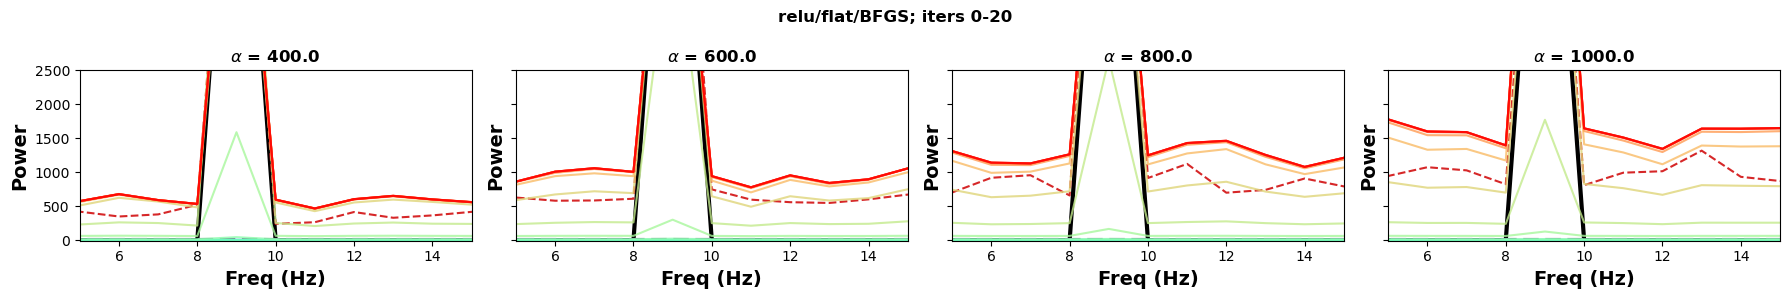

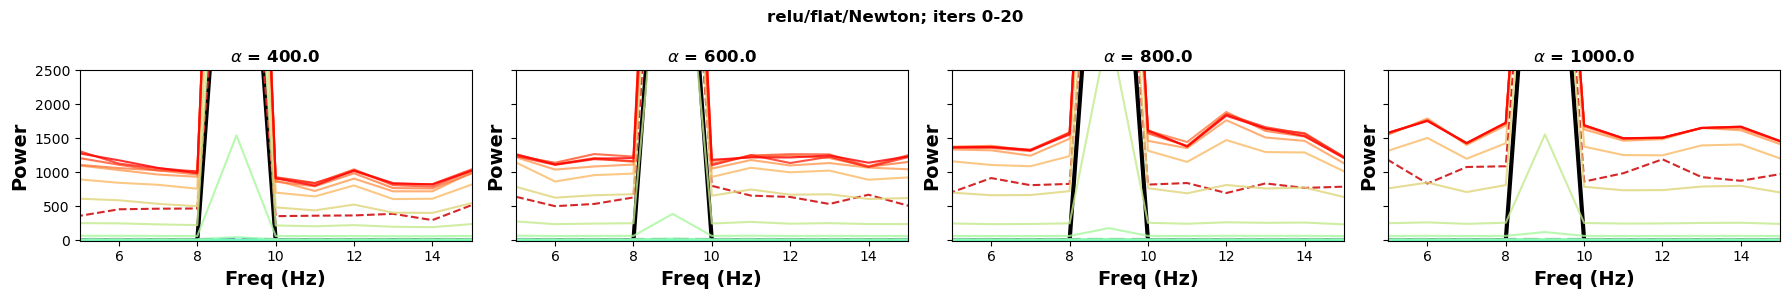

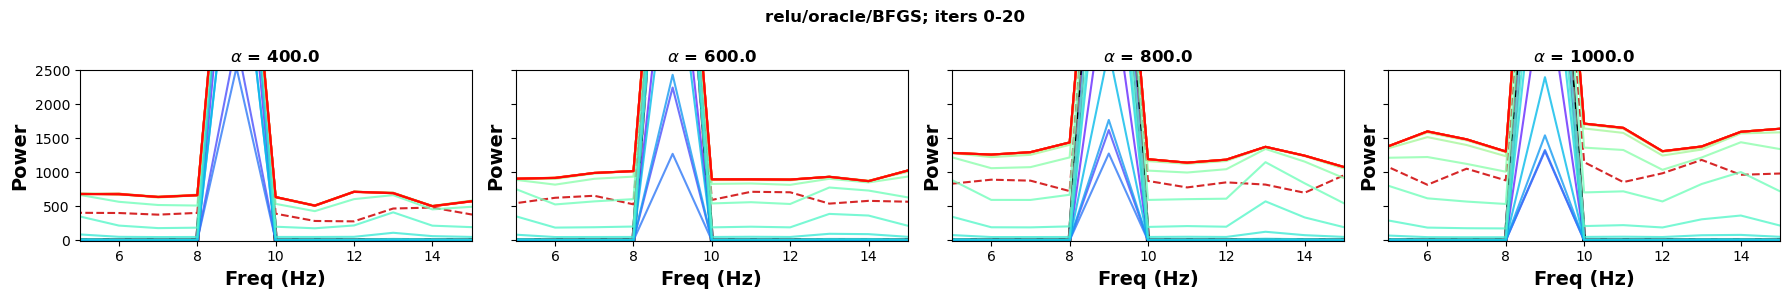

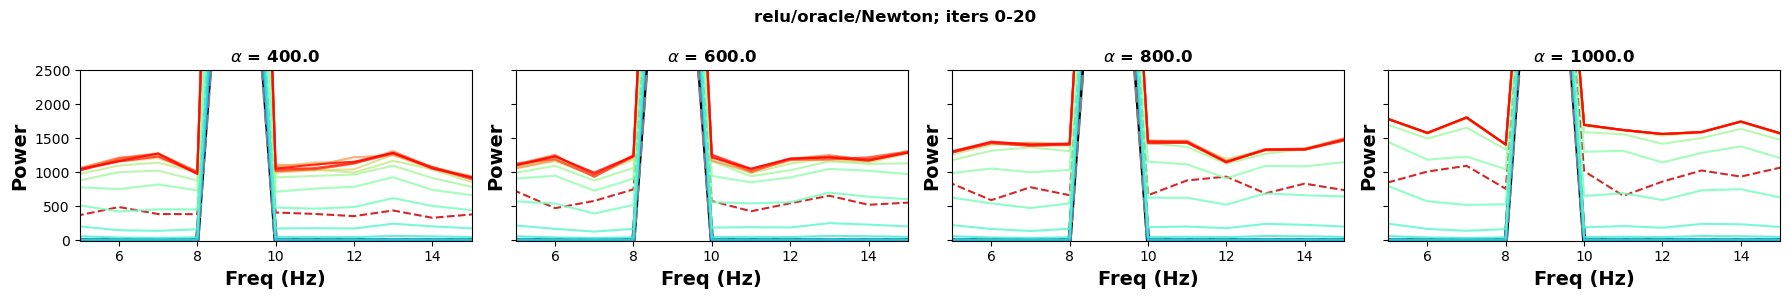

In [60]:

link = 'relu'
init_type = 'oracle'
optim_type = 'BFGS'
delta = 1e-3
sample_length=1000
fs = 1000
J = sample_length/2
# scaling_factor = (delta**2)*(2*(np.pi**2))
# scaling_factor = (delta**2)*(2*(np.pi**2)*(1/fs)*(1/((sample_length/2)**2)))
# scaling_factor = (2*(np.pi**2/fs)*(sample_length/((sample_length/2)**2)))
# scaling_factor = (2*(np.pi)/fs)*(np.pi/J)*(sample_length/J)
scaling_factor = ((np.pi)/fs)*(np.pi/J)*(sample_length/J)

for init_type in ['flat', 'oracle']:
    for optim_type in ['BFGS', 'Newton']:

        alphas = [400, 600, 800, 1000]
        logS = False
        iters_show = [0,20]
        fig, ax = plt.subplots(1,4,figsize=(18,3), sharey=True)
        for a, alpha in enumerate(alphas):
            alpha = float(alpha)
            plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, ax=ax[a], k=1, scaling_factor=scaling_factor, title=False, emiter=20)
            # plt.ylim([5000,9000])
            ax[a].set_xlim([5,15])
            ax[a].set_ylim([-5,2500])

        fig.suptitle(f'{link}/{init_type}/{optim_type}; iters {iters_show[0]}-{iters_show[1]}', fontweight='bold', fontsize=12)
        plt.tight_layout()


400.0



(5.0, 15.0)

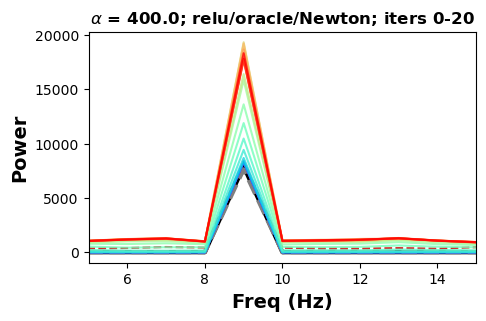

In [28]:
link = 'relu'
init_type = 'oracle'
optim_type = 'Newton'
alpha = 400.0
fs = 1000
sample_length = 1000
J = 500
scaling_factor = ((np.pi)/fs)*(np.pi/J)*(sample_length/J)

logS = False
iters_show = [0,20]
# plot_res_S('relu', init_type, optim_type, alpha, False, [0,20],emiter=20)
# plt.ylim([5000,9000])
plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, k=1, scaling_factor=scaling_factor, title=True, emiter=20)
plt.xlim([5,15])



400.0



(5.0, 15.0)

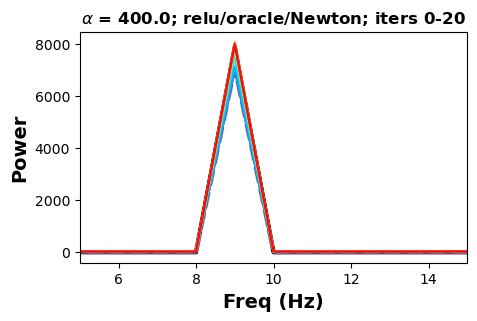

In [35]:
# plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, k=1, scaling_factor=scaling_factor, title=True, emiter=20, C=25, L=100)
plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, k=1, scaling_factor=scaling_factor, title=True, emiter=20)
plt.xlim([5,15])

400.0



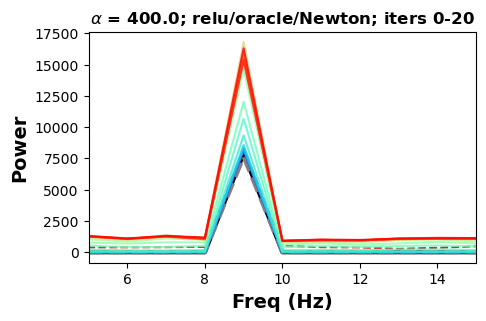

400.0



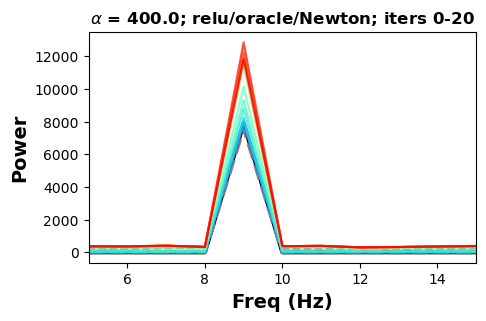

400.0



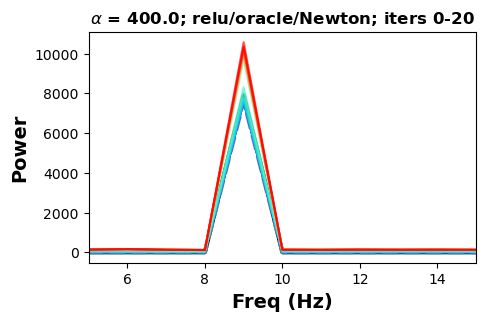

400.0



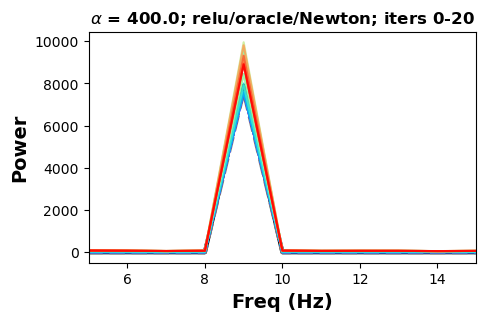

400.0



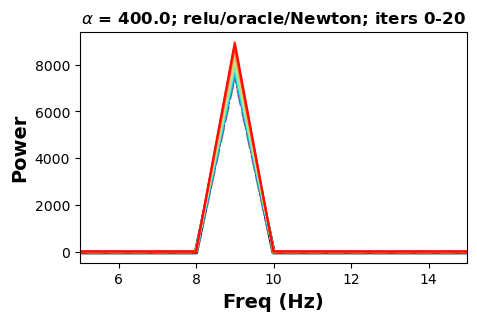

In [40]:
Cs = [1, 2, 5, 10, 20]
for C in Cs:
    plot_res_S('relu', init_type, optim_type, alpha, logS, iters_show, k=1, scaling_factor=scaling_factor, title=True, emiter=20, C=C, L=50)
    plt.xlim([5,15])
    plt.show()

300.0

300.0



(5.0, 15.0)

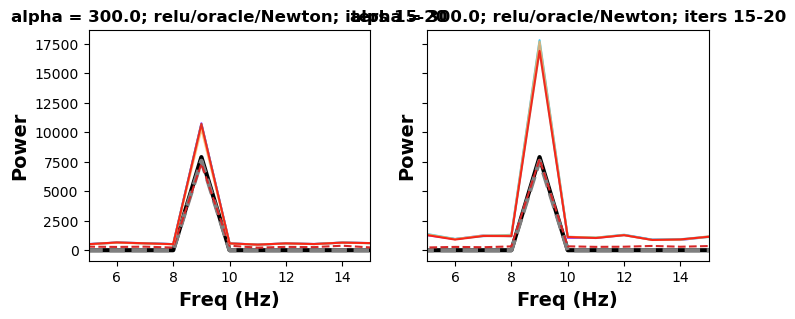

In [88]:

link = 'relu'
init_type = 'oracle'
optim_type = 'Newton'
alpha = 300.0

fig, ax = plt.subplots(1,2,figsize=(8,3),sharey=True)
plot_res_S('relu', init_type, optim_type, alpha, False, [15,20], ax=ax[0], emiter=20)
plot_res_S('relu', init_type, optim_type, alpha, False, [15,20], ax=ax[1], emiter=50)
# plt.ylim([5000,9000])
ax[0].set_xlim([5,15])
ax[1].set_xlim([5,15])





In [14]:
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [10]:
seed = 8
win=1000
L=50
C=1
emiter=50
K=2

alpha=float(alpha)
alphas = np.array([alpha, alpha])

sample_length = win
em_iters = emiter

model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
data_path = f'saved/synthetic_data/simple_synthetic_delta{link}poisson_fixed_gamma_{K}_{L}_{sample_length}'


model_load = pickle_open(model_path)
data_load = pickle_open(data_path)

In [11]:
r = 6
model_load['track'][0][r]['gamma'][:,0,0]

array([2.54045353e+05+0.j, 3.11704847e+05+0.j, 2.46075391e+05+0.j,
       3.44404215e+05+0.j, 4.08625356e+05+0.j, 2.97960502e+05+0.j,
       3.47420449e+05+0.j, 3.04569460e+05+0.j, 3.45693684e+05+0.j,
       2.22450341e+08+0.j, 2.76053273e+05+0.j, 3.46844457e+05+0.j,
       3.13761456e+05+0.j, 3.60348406e+05+0.j, 3.63704490e+05+0.j,
       3.19527955e+05+0.j, 4.08923911e+05+0.j, 2.70223769e+05+0.j,
       2.83339319e+05+0.j, 3.37819446e+05+0.j, 3.26595679e+05+0.j,
       2.93184550e+05+0.j, 3.09702270e+05+0.j, 3.27738631e+05+0.j,
       3.22045443e+05+0.j, 3.37546133e+05+0.j, 2.39240495e+05+0.j,
       3.54587358e+05+0.j, 2.80061670e+05+0.j, 3.72502020e+05+0.j,
       2.95033021e+05+0.j, 3.06225733e+05+0.j, 2.77366703e+05+0.j,
       3.10342374e+05+0.j, 4.13662733e+05+0.j, 3.22763937e+05+0.j,
       3.63670197e+05+0.j, 2.87919674e+05+0.j, 3.06686790e+05+0.j,
       3.09002223e+05+0.j, 2.71726118e+05+0.j, 3.34004947e+05+0.j,
       3.08409201e+05+0.j, 3.16191822e+05+0.j, 2.89518839e+05+

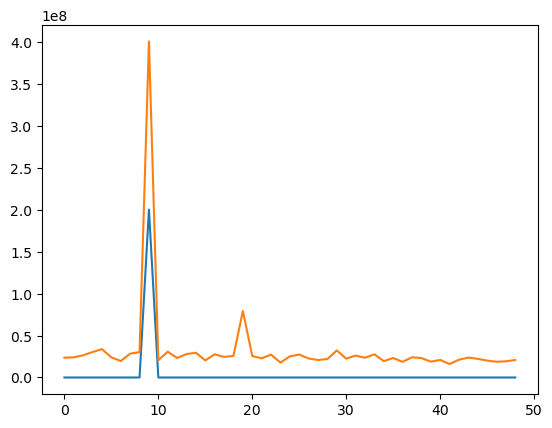

In [12]:
k = 0
num_J_vars = model_load['Wv'].shape[1]
Gamma_true = data_load['latent']['Gamma'][:int(num_J_vars/2)]
Gamma_est = model_load['Gamma']
plt.plot(Gamma_true[:,k,k].real)
plt.plot(Gamma_est[:,k,k].real)

In [15]:
delta = 1e-3
Wv = model_load['Wv']
num_J_vars = Wv.shape[1]
Gamma_true = data_load['latent']['Gamma'][:int(num_J_vars/2)]
Gamma_true.shape
spikes = model_load['spikes']
lams_true = model_load['lams']

if spikes.shape[1] == 1:
    spikes = spikes[:,0,:,:]

# gamma_r = model_load['track'][0][r-1]['gamma']
# gamma_r_inv = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
Gamma_true_inv = np.linalg.inv(Gamma_true)
Gamma_true.shape
J = int(num_J_vars/2)

Gamma_real = np.stack([reverse_rearrange_mat(transform_cov_c2r(Gamma_true[j,:,:]), K) for j in range(J)])
Gamma_real_inv = np.stack([reverse_rearrange_mat(transform_cov_c2r(Gamma_true_inv[j,:,:]), K) for j in range(J)])


In [16]:
r = 1
mus = model_load['track'][0][r]['mus']
Ups_invs = model_load['track'][0][r]['Ups_invs']
Sig_complex = model_load['track'][0][r]['Sig_complex']

In [17]:
Jv = num_J_vars
v = mus[0,:]
temp = [v[k*Jv:k*Jv + Jv] for k in range(K)]

In [18]:
def get_freq_vecs_real(vec, K, num_J_vars):
    """
    Un-vectorize over frequencies.
    """
    j_vecs = []
    for jv in range(0, num_J_vars, 2):
        base_filt = np.zeros(num_J_vars)
        base_filt[jv : jv + 2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        vec_j = vec[j_filt]
        j_vecs.append(vec_j)
    return j_vecs

In [25]:
vec = mus[0,:]
j_vecs = []
for jv in range(0, num_J_vars, 2):
    base_filt = np.zeros(num_J_vars)
    base_filt[jv : jv + 2] = 1
    j_filt = np.tile(base_filt.astype(bool), K)
    vec_j = vec[j_filt]
    j_vecs.append(vec_j)

In [26]:
# from scipy.linalg import block_diag
# from cohlib.alg.em_sgc import get_freq_vecs_real
# L = mus.shape[0]

# J = int(num_J_vars / 2)
# mus_outer = np.zeros((L, J, K * 2, K * 2))
# Upss = np.zeros((L, J, K * 2, K * 2))

# for l in range(L):
#     Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
#     mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
#     for j in range(J):
#         mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
#         Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

# mus_conv = np.zeros((L, J, K * 2, K * 2))
# Ups_invs_conv = np.zeros((L, J, K * 2, K * 2))

# for l in range(L):
#     Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
#     mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
#     for j in range(J):
#         mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
#         Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

# # enforce circulary symmetry
# k_mask_pre = 1 - np.eye(2)
# k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
# k_mask = 1 - k_mask_inv

# Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
# Sigmas_complex = np.zeros((L, J, K, K), dtype=complex)
# for l in range(L):
#     Sig_real = mus_outer[l, :, :, :] * k_mask + Upss[l, :, :, :]
#     Sig_complex = np.zeros((J, K, K), dtype=complex)
#     for j in range(J):
#         Sig_complex[j, :, :] = transform_cov_r2c(
#             rearrange_mat(Sig_real[j, :, :], K)
#         )
#     Gamma_update_complex += Sig_complex
#     Sigmas_complex[l,:,:,:] = Sig_complex

# Gamma_update_complex = Gamma_update_complex / L

In [27]:
def update_Gamma_complex(mus, Ups_invs, K, num_J_vars):
    """
    M-Step

    mus is (trials x num_J_vars * K)
    Ups_inv is (trials x num_J_vars * K x num_J_vars * K)
    """
    L = mus.shape[0]

    J = int(num_J_vars / 2)
    mus_outer = np.zeros((L, J, K * 2, K * 2))
    Upss = np.zeros((L, J, K * 2, K * 2))

    for l in range(L):
        Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
        mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
        for j in range(J):
            mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
            Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

    # enforce circulary symmetry
    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask = 1 - k_mask_inv

    Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
    Sigmas_complex = np.zeros((L, J, K, K), dtype=complex)
    for l in range(L):
        Sig_real = mus_outer[l, :, :, :] * k_mask + Upss[l, :, :, :]
        Sig_complex = np.zeros((J, K, K), dtype=complex)
        for j in range(J):
            Sig_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Sig_real[j, :, :], K)
            )
        Gamma_update_complex += Sig_complex
        Sigmas_complex[l,:,:,:] = Sig_complex

    Gamma_update_complex = Gamma_update_complex / L

    return Gamma_update_complex, Sigmas_complex

In [28]:
np.round(Gamma_true[9,:,:],3)

array([[2.00e+08+0.j, 1.84e+08-0.j],
       [1.84e+08+0.j, 2.00e+08+0.j]])

In [29]:
np.round(Gamma_real[9,:,:],3)

array([[ 1.0e+08, -0.0e+00,  9.2e+07,  0.0e+00],
       [ 0.0e+00,  1.0e+08, -0.0e+00,  9.2e+07],
       [ 9.2e+07, -0.0e+00,  1.0e+08, -0.0e+00],
       [ 0.0e+00,  9.2e+07,  0.0e+00,  1.0e+08]])

In [30]:
# from cohlib.alg.em_sgc import get_freq_vecs_real
# vjs = np.stack(get_freq_vecs_real(mus_r[l], K, num_J_vars))
# latent_sum = 0
# for j in range(J):
#     quad_term = vjs[j,:].T @ Gamma_real_inv[j,:,:] @ vjs[j,:]
#     norm_term = np.log(np.linalg.det(Gamma_real[j,:,:])) + K*np.log(2*np.pi)
#     latent_sum += -(1/2)*(quad_term+norm_term)

In [31]:
# vjs = np.stack(get_freq_vecs_real(mus_r[l], K, num_J_vars))
# from cohlib.conv import conv_v_to_z
# from cohlib.conv import conv_v_to_z_vec
# from cohlib.conv import conv_z_to_v_vec
# j = 5
# zj = conv_v_to_z(vjs[j,:], axis=0, dc=False)

In [44]:
def CDLL(spikes, mus, W, Gamma_real, Gamma_real_inv, alphas, delta=1e-3):
    K = alphas.size
    num_J_vars = W.shape[1]
    J = int(num_J_vars/2)
    vs = np.zeros((L,K,num_J_vars))
    for k in range(K):
        vs[:,k,:] = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
    xs = np.einsum('ij,lkj->lki', W, vs)
    lams = cif_alpha_relu(alphas, xs)

    lams[lams<=0] = np.nan
    # obs_sum = (spikes*np.nan_to_num(np.log(lams*delta)) - (lams*delta)).sum()
    obs_sum = (spikes*np.nan_to_num(np.log(lams*delta),nan=0, neginf=0, posinf=0) - (np.nan_to_num(lams)*delta)).sum()
    # obs_sum = (spikes*np.log(lams*delta) - (lams*delta)).sum()

    latent_sum = 0
    for l in range(L):
        vjs = np.stack(get_freq_vecs_real(mus[l,:], K, num_J_vars))
        for j in range(J):
            quad_term = vjs[j,:].T @ Gamma_real_inv[j,:,:] @ vjs[j,:]
            norm_term = np.log(1/np.linalg.det(Gamma_real[j,:,:])) + K*np.log(2*np.pi)
            latent_sum += (1/2)*(quad_term+norm_term)
    complete_ll = obs_sum - latent_sum 
    return complete_ll, obs_sum, latent_sum


In [45]:
Gamma_real_inv.shape

(49, 4, 4)

In [47]:
from cohlib.alg.em_sgc import get_freq_vecs_real
cdlls = []
obs_sums = []
latent_sums = []
for r in range(em_iters):
    mus_r = model_load['track'][0][r]['mus']
    complete_ll, os, ls = CDLL(spikes, mus_r, Wv, Gamma_real, Gamma_real_inv, alphas)
    cdlls.append(complete_ll)
    obs_sums.append(os)
    latent_sums.append(ls)

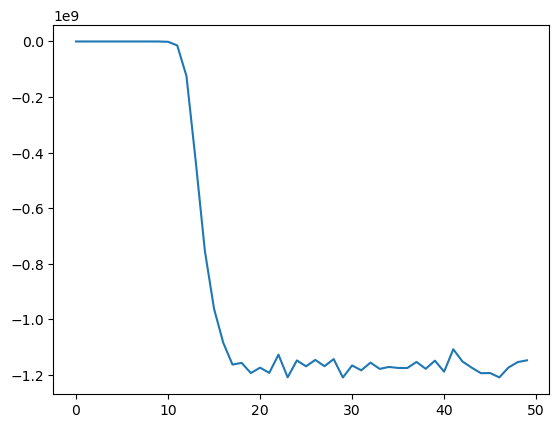

In [48]:
plt.plot(cdlls)

In [208]:
# r = 10
# mus_r = model_load['track'][0][r-1]['mus']
# for k in range(K):
#     mus_r_k = mus_r[:,k*num_J_vars:k*num_J_vars+num_J_vars]
#     plt.plot(Wv[None,:,:] @ mus_r_k)

In [44]:
from scipy.linalg import block_diag
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def update_Gamma_complex_mod(mus, Ups_invs, K, num_J_vars):
    """
    M-Step

    mus is (trials x num_J_vars * K)
    Ups_inv is (trials x num_J_vars * K x num_J_vars * K)
    """
    L = mus.shape[0]

    J = int(num_J_vars / 2)
    mus_outer = np.zeros((L, J, K * 2, K * 2))
    Upss = np.zeros((L, J, K * 2, K * 2))

    for l in range(L):
        Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
        mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
        for j in range(J):
            mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])

            Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

    # enforce circulary symmetry
    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask = 1 - k_mask_inv

    Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
    Gamma_mu_update_complex = np.zeros((J, K, K), dtype=complex)
    Gamma_Upss_update_complex = np.zeros((J, K, K), dtype=complex)
    for l in range(L):
        Psi_mu_real = mus_outer[l,:,:,:]
        Psi_mu_complex = np.zeros((J, K, K), dtype=complex)

        Psi_Upss_real = Upss[l, :, :, :]
        Psi_Upss_complex = np.zeros((J, K, K), dtype=complex)

        Sig_real = mus_outer[l, :, :, :] * k_mask + Upss[l, :, :, :]
        Psi_real = Sig_real
        Psi_complex = np.zeros((J, K, K), dtype=complex)


        for j in range(J):
            Psi_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Psi_real[j, :, :], K)
            )

            Psi_mu_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Psi_mu_real[j, :, :], K)
            )
            Psi_Upss_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Psi_Upss_real[j, :, :], K)
            )

        Gamma_update_complex += Psi_complex
        Gamma_mu_update_complex += Psi_mu_complex
        Gamma_Upss_update_complex += Psi_Upss_complex

    Gamma_update_complex = Gamma_update_complex / L
    Gamma_mu_update_complex = Gamma_mu_update_complex / L
    Gamma_Upss_update_complex = Gamma_Upss_update_complex / L

    return Gamma_update_complex, Gamma_mu_update_complex, Gamma_Upss_update_complex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [2]:
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [3]:
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))

In [4]:
# zs = data_load['latent']['zs']
# k = 0 
# # fig, ax = plt.subplots(1,2)
# for l in range(L):
#     plt.plot(zs[l,k,:].real, color='blue')
#     plt.plot(zs[l,k,:].imag, color='red')
# plt.xlim([0,20])
# vs = data_load['latent']['vs']
# k = 0 
# # fig, ax = plt.subplots(1,2)
# for l in range(L):
#     plt.plot(vs[l,0,:], '.', color='blue')
# # plt.xlim([10,20])

In [5]:
link = 'relu'
init_type = 'oracle'
optim_type = 'Newton'
alpha = 400.0
delta = 1e-3
sample_length=1000
fs = 1000
J = sample_length/2
# scaling_factor = (delta**2)*(2*(np.pi**2))
# scaling_factor = (delta**2)*(2*(np.pi**2)*(1/fs)*(1/((sample_length/2)**2)))
# scaling_factor = (2*(np.pi**2/fs)*(sample_length/((sample_length/2)**2)))
# scaling_factor = (2*(np.pi)/fs)*(np.pi/J)*(sample_length/J)
scaling_factor = ((np.pi)/fs)*(np.pi/J)*(sample_length/J)
plot_res_S('relu', init_type, optim_type, alpha, False, [0,20], k=1, scaling_factor=scaling_factor, emiter=20)
# plt.ylim([5000,9000])
plt.xlim([5,15])



NameError: name 'plot_res_S' is not defined

In [7]:
link = 'relu'
init_type = 'oracle'
optim_type = 'Newton'
seed = 8
win=1000
L=50
C=1
emiter=20
K=2
alpha = 400

alpha=float(alpha)
alphas = np.array([alpha, alpha])

sample_length = win
em_iters = emiter

model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
data_path = f'saved/synthetic_data/simple_synthetic_delta{link}poisson_fixed_gamma_{K}_{L}_{sample_length}'


# model_load = pickle_open(model_path)
data_load = pickle_open(data_path)

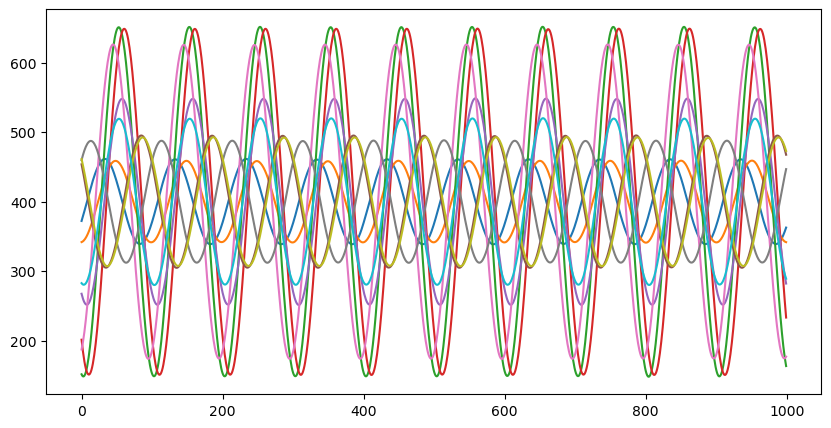

In [11]:
l = 25
k = 0
xs = data_load['latent']['xs']
lams = data_load['observed']['lams']
spikes = data_load['observed']['spikes']

# fig, ax = plt.subplots(2,1,figsize=(10,5))
# ax[0].plot(spikes[l,0,k,:])
# ax[1].plot(xs[l,k,:])
# ax[0].margins(0)
# ax[1].margins(0)
# plt.tight_layout()
fig, ax = plt.subplots(1,figsize=(10,5))
for l in range(10):
    ax.plot(lams[l,k,:])

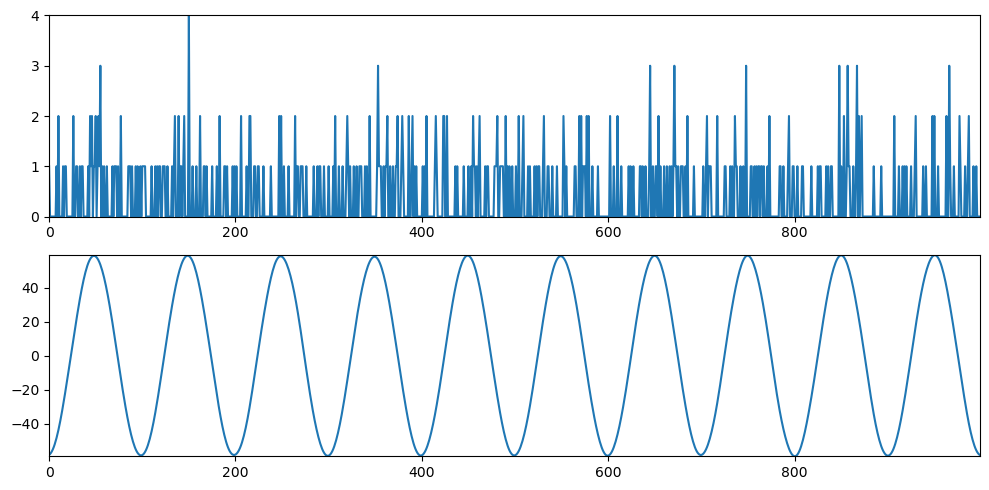

In [10]:
l = 1
k = 0
xs = data_load['latent']['xs']
spikes = data_load['observed']['spikes']

fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(spikes[l,0,k,:])
ax[1].plot(xs[l,k,:])
ax[0].margins(0)
ax[1].margins(0)
plt.tight_layout()

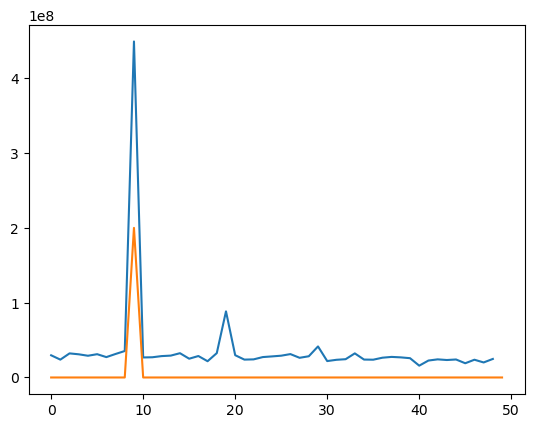

In [216]:
plt.plot(model_load['Gamma'][:50,0,0].real)
plt.plot(data_load['latent']['Gamma'][:50,0,0].real)

In [217]:
a = model_load['Gamma'][:49,0,0].real
b = data_load['latent']['Gamma'][:49,0,0].real
a/b

array([1.48306040e+06, 1.19313253e+06, 1.61018259e+06, 1.54880561e+06,
       1.45272725e+06, 1.55650923e+06, 1.36191365e+06, 1.57121454e+06,
       1.76893286e+06, 2.24600786e+00, 1.33892930e+06, 1.35137084e+06,
       1.42864427e+06, 1.46185953e+06, 1.62305322e+06, 1.25466819e+06,
       1.43404843e+06, 1.08671784e+06, 1.62845688e+06, 4.41963803e+06,
       1.48992068e+06, 1.19448936e+06, 1.20975064e+06, 1.36381783e+06,
       1.40860237e+06, 1.45628097e+06, 1.56295161e+06, 1.31507966e+06,
       1.41878525e+06, 2.07547356e+06, 1.09680202e+06, 1.18154377e+06,
       1.22176504e+06, 1.61104700e+06, 1.19757916e+06, 1.18833721e+06,
       1.32205622e+06, 1.37524441e+06, 1.34364959e+06, 1.28961297e+06,
       7.89692840e+05, 1.13222162e+06, 1.21099888e+06, 1.16715481e+06,
       1.20278291e+06, 9.51333872e+05, 1.18680117e+06, 1.00446507e+06,
       1.23916223e+06])

In [197]:
from cohlib.alg.em_sgc import deconstruct_Gamma_full_real
model_load['inv_init']
test = deconstruct_Gamma_full_real(model_load['inv_init'], K, num_J_vars, invert=True)
gamma_

In [202]:
test_reverse = construct_Gamma_full_real(test, K, num_J_vars, invert=True)

In [206]:
np.all(np.isclose(model_load['inv_init'], test_reverse))

True

In [39]:
def Q_func_real(Gamma_real_r, Gamma_real_r_inv, Sigmas_real_r):
    L = Sigmas_real_r.shape[0]
    K = Gamma_real_r_inv.shape[1]
    sum_A = L*( (K*np.log(2*np.pi) + np.log(np.linalg.det(Gamma_real_r)))).sum()
    # sum_A = L*np.log(2*np.pi**K * (1/np.linalg.det(Gamma_real_r_inv))).sum()
    sum_B = np.trace(Gamma_real_r_inv @ Sigmas_real_r, axis1=2, axis2=3).sum()
    Q = -(1/2)*(sum_A + sum_B)

    return sum_A, sum_B, Q.real

In [40]:
def Q_func(Gamma_r, Gamma_r_inv, Sigmas_r):
    L = Sigmas_r.shape[0]
    K = Gamma_r_inv.shape[1]
    sum_A = L*(K*np.log(np.pi) + np.log(np.abs(np.linalg.det(Gamma_r)))).sum()
    sum_B = np.trace(Gamma_r_inv @ Sigmas_r, axis1=2, axis2=3).sum()
    Q = -(sum_A + sum_B)

    return sum_A, sum_B, Q.real

In [41]:
def get_Qs_complex(alpha, link, init_type, optim_type, #scaling_factor=scaling_factor, 
                sample_length=1000,
                L=50,
                C=1,
                emiter=20,
                K=2):

    model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{emiter}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
    model_load = pickle_open(model_path)

    Qs = []
    # As = []
    # Bs = []
    for r in range(1, em_iters):
        gamma_r = model_load['track'][0][r-1]['gamma']
        # gamma_r_inv = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = np.linalg.inv(gamma_r)
        sig_r = model_load['track'][0][r]['Sig_complex']

        A, B, Q = Q_func(gamma_r, gamma_r_inv, sig_r)
        Qs.append(Q.real)
        # As.append(A.real)
        # Bs.append(B.real)

    return np.array(Qs) 

        
def get_Qs_real(alpha, link, init_type, optim_type, #scaling_factor=scaling_factor, 
                sample_length=1000,
                L=50,
                C=1,
                emiter=20,
                K=2):

    model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{emiter}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
    model_load = pickle_open(model_path)

    Qs = []
    # As = []
    # Bs = []
    for r in range(1, em_iters):
        gamma_r = model_load['track'][0][r-1]['gamma']
        J = gamma_r.shape[0]
        # gamma_r_inv = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = np.linalg.inv(gamma_r)
        sig_r = model_load['track'][0][r]['Sig_complex']

        gamma_real_r = np.stack([quick_conv_c2r(gamma_r[j,:,:],K) for j in range(J)])
        gamma_real_r_inv = np.stack([quick_conv_c2r(gamma_r_inv[j,:,:],K) for j in range(J)])

        sig_real_r = np.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = np.stack([quick_conv_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r[l,:,:,:] = sig_real_rl


        A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        Qs.append(Q)
        # As.append(A)
        # Bs.append(B)

    return np.array(Qs) 

        

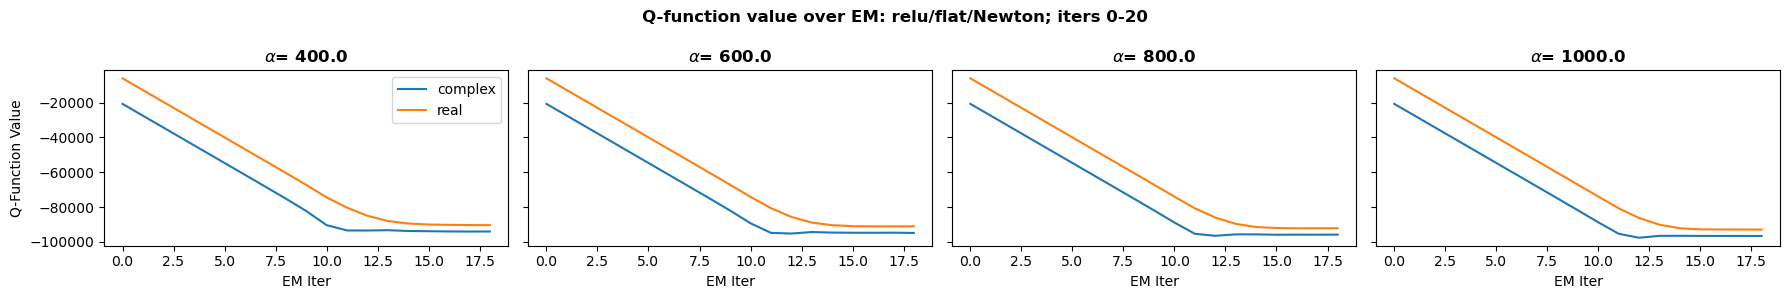

In [56]:
link = 'relu'
# init_type = 'oracle'
# optim_type = 'Newton'
seed = 8
win=1000
L=50
C=1
emiter=20
K=2

sample_length = win
em_iters = emiter

init_type = 'flat'
optim_type = 'Newton'

fig, ax = plt.subplots(1,4, figsize=(18,3), sharey=True)
alphas = [400, 600, 800, 1000]
for a, alpha in enumerate(alphas):
    alpha = float(alpha)
    Qs_complex = get_Qs_complex(alpha, link, init_type, optim_type)
    Qs_real = get_Qs_real(alpha, link, init_type, optim_type)
    ax[a].plot(Qs_complex, label='complex')
    ax[a].plot(Qs_real, label='real')
    ax[a].set_title(r'$\alpha$' + f'= {alpha}', fontweight='bold', fontsize=12)
    ax[a].set_xlabel('EM Iter')
    if a == 0:
        ax[a].set_ylabel('Q-Function Value')
        ax[a].legend()

fig.suptitle(f'Q-function value over EM: {link}/{init_type}/{optim_type}; iters {iters_show[0]}-{iters_show[1]}', fontweight='bold', fontsize=12)
plt.tight_layout()


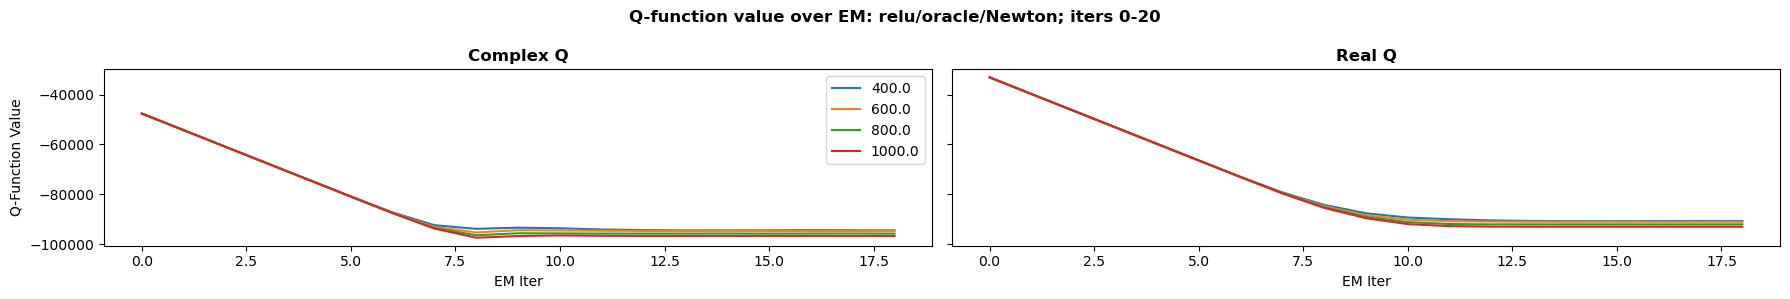

In [55]:

fig, ax = plt.subplots(1,2, figsize=(18,3), sharey=True)
alphas = [400, 600, 800, 1000]
for a, alpha in enumerate(alphas):
    alpha = float(alpha)
    Qs_complex = get_Qs_complex(alpha, link, init_type, optim_type)
    Qs_real = get_Qs_real(alpha, link, init_type, optim_type)
    ax[0].plot(Qs_complex, label=f'{alpha}')
    ax[1].plot(Qs_real)
    ax[0].set_title(f'Complex Q', fontweight='bold', fontsize=12)
    ax[1].set_title(f'Real Q', fontweight='bold', fontsize=12)
    ax[0].set_xlabel('EM Iter')
    ax[1].set_xlabel('EM Iter')
    ax[0].set_ylabel('Q-Function Value')
    ax[0].legend()

fig.suptitle(f'Q-function value over EM: {link}/{init_type}/{optim_type}; iters {iters_show[0]}-{iters_show[1]}', fontweight='bold', fontsize=12)
plt.tight_layout()


In [223]:
# np.log(np.linalg.det(gamma_r))
sum_A

(89268.3385019283+2.5683929888876653e-16j)

In [57]:
Qs = []
As = []
Bs = []
for r in range(1, em_iters):
    gamma_r = model_load['track'][0][r-1]['gamma']
    # gamma_r_inv = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
    gamma_r_inv = np.linalg.inv(gamma_r)
    sig_r = model_load['track'][0][r]['Sig_complex']

    A, B, Q = Q_func(gamma_r, gamma_r_inv, sig_r)
    Qs.append(Q.real)
    As.append(A.real)
    Bs.append(B.real)

cQs = Qs
cAs = As
cBs = Bs

# next, what 

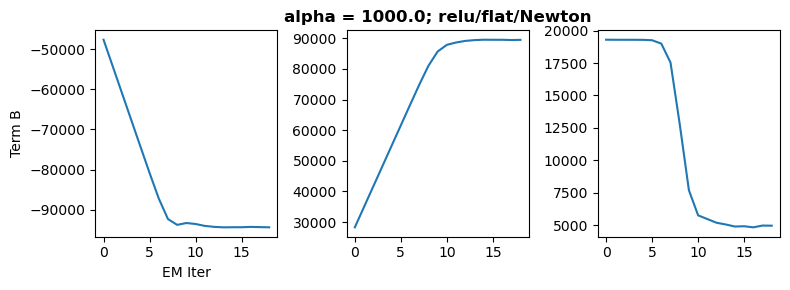

In [58]:
fig, ax = plt.subplots(1,3,figsize=(8,3))
ax[0].plot(Qs)
# ax[0].set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
ax[0].set_xlabel('EM Iter')
ax[0].set_ylabel('Q-Function Value')

ax[1].plot(As)
ax[1].set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
ax[0].set_xlabel('EM Iter')
ax[0].set_ylabel('Term A')


ax[2].plot(Bs)
ax[0].set_xlabel('EM Iter')
ax[0].set_ylabel('Term B')
plt.tight_layout()

In [261]:
J = gamma_r.shape[0]
Qs = []
As = []
Bs = []
for r in range(1, em_iters):
    gamma_r = model_load['track'][0][r-1]['gamma']
    # gamma_r_inv = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
    gamma_r_inv = np.linalg.inv(gamma_r)
    sig_r = model_load['track'][0][r]['Sig_complex']

    gamma_real_r = np.stack([quick_conv_c2r(gamma_r[j,:,:],K) for j in range(J)])
    gamma_real_r_inv = np.stack([quick_conv_c2r(gamma_r_inv[j,:,:],K) for j in range(J)])

    sig_real_r = np.zeros((L,J,2*K,2*K))
    for l in range(L):
        sig_real_rl = np.stack([quick_conv_c2r(sig_r[l,j,:,:],K) for j in range(J)])
        sig_real_r[l,:,:,:] = sig_real_rl


    A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
    Qs.append(Q)
    As.append(A)
    Bs.append(B)

rQs = Qs
rAs = As
rBs = Bs

# next, what 

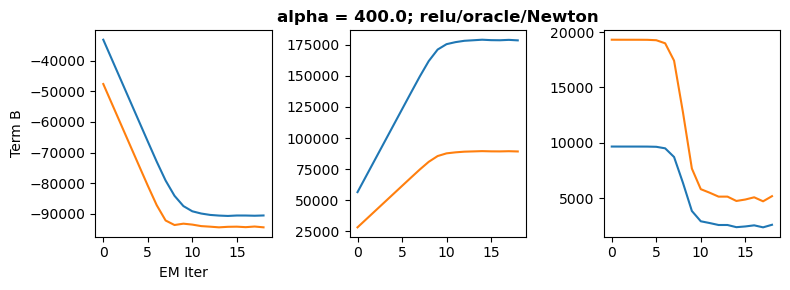

In [262]:
fig, ax = plt.subplots(1,3,figsize=(8,3))
ax[0].plot(rQs)
ax[0].plot(cQs)
# ax[0].set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
ax[0].set_xlabel('EM Iter')
ax[0].set_ylabel('Q-Function Value')

ax[1].plot(rAs)
ax[1].plot(cAs)
ax[1].set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
ax[0].set_xlabel('EM Iter')
ax[0].set_ylabel('Term A')


ax[2].plot(rBs)
ax[2].plot(cBs)
ax[0].set_xlabel('EM Iter')
ax[0].set_ylabel('Term B')
plt.tight_layout()

In [264]:
np.exp(np.array(rQs) / np.array(cQs))

array([2.00537159, 2.08168515, 2.14327619, 2.19405703, 2.23669936,
       2.27345561, 2.30883116, 2.35930885, 2.45479738, 2.55578689,
       2.59476438, 2.60202584, 2.60959541, 2.6098091 , 2.61778626,
       2.61502834, 2.61102735, 2.61832946, 2.60897817])

Text(0, 0.5, 'Q-Function Value')

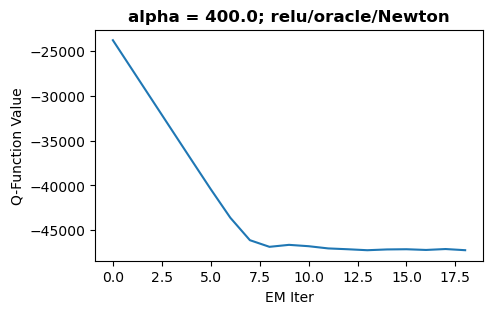

In [228]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(Qs)
ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
ax.set_xlabel('EM Iter')
ax.set_ylabel('Q-Function Value')

In [28]:
gamma_r_inv_test = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(J)])

In [29]:
np.all(gamma_r_inv == gamma_r_inv_test)

True

In [30]:
gamma_sig_quick = (gamma_r_inv @ sig_r)

In [31]:
np.trace(np.eye(5))

5.0

In [87]:
L = sig_r.shape[0]
J = sig_r.shape[1]
gamma_sig_product = np.zeros_like(sig_r)
trace_sum = 0
for l in range(L):
    for j in range(J):
        product_lj = gamma_r_inv[j,:,:] @ sig_r[l,j,:,:]
        gamma_sig_product[l,j,:,:] = product_lj
        trace_sum += np.trace(product_lj)




In [90]:
np.all(gamma_sig_product == gamma_sig_quick)

True

In [91]:
quick_trace_sum = np.trace(gamma_sig_quick, axis1=2, axis2=3).sum()

In [96]:
np.isclose(trace_sum, quick_trace_sum)

True

In [77]:
sig_r.shape

(50, 49, 2, 2)

Text(0, 0.5, 'Q-Function Value')

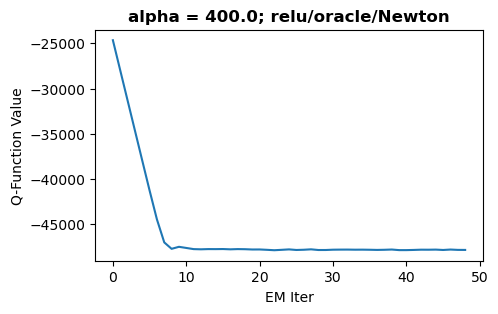

In [32]:

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(Qs)
ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
ax.set_xlabel('EM Iter')
ax.set_ylabel('Q-Function Value')

Text(0, 0.5, 'Q-Function Value')

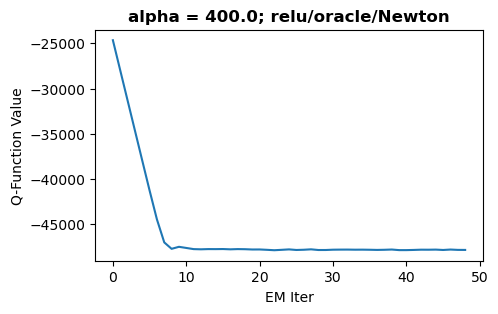

In [67]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(Qs)
ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}', fontweight='bold', fontsize=12)
ax.set_xlabel('EM Iter')
ax.set_ylabel('Q-Function Value')

In [68]:
np.diff(np.array(Qs))

array([-3.32723126e+03, -3.32709049e+03, -3.32692291e+03, -3.32566031e+03,
       -3.31301932e+03, -3.19515235e+03, -2.54600569e+03, -7.10049991e+02,
        2.23149754e+02, -1.25901389e+02, -1.28602260e+02, -2.13505754e+01,
        2.34951402e+01, -3.29927089e+00,  9.00151636e+00, -3.17353356e+01,
        2.55052207e+01, -1.24466949e+01, -3.16057990e+01,  3.06266459e+00,
       -3.90181274e+01, -4.43367030e+01,  4.40075971e+01,  4.72002121e+01,
       -6.38385932e+01,  2.47063754e+01,  4.59140982e+01, -7.45443500e+01,
        1.27134150e+00,  3.32399146e+01,  9.07826698e+00,  3.04276218e+00,
       -1.19523196e+01,  4.42524249e+00, -1.10972225e+01, -1.80589319e+01,
        1.54299083e+01,  2.71034251e+01, -6.41126820e+01, -1.10648538e-02,
        2.02883627e+01,  2.73515340e+01, -3.66321177e+00,  1.19881180e+01,
       -4.02571504e+01,  4.69593247e+01, -3.70336308e+01, -4.73774786e+00])

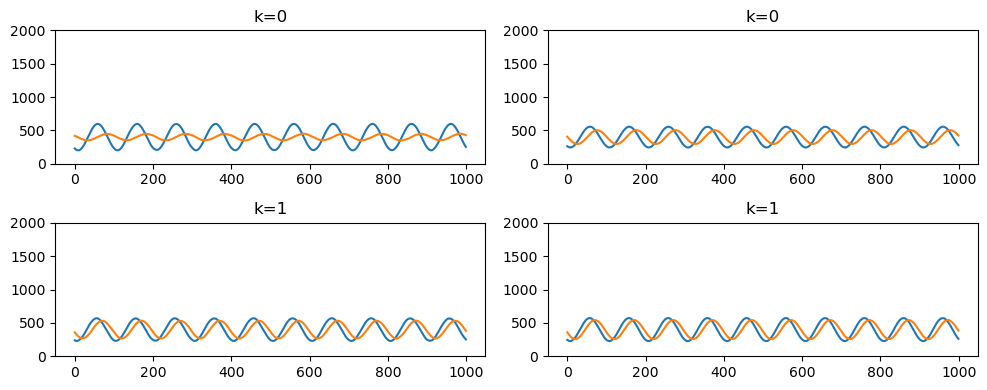

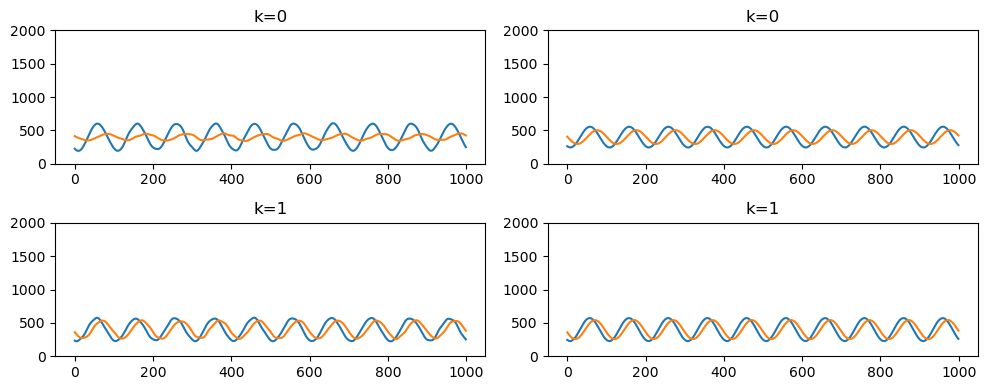

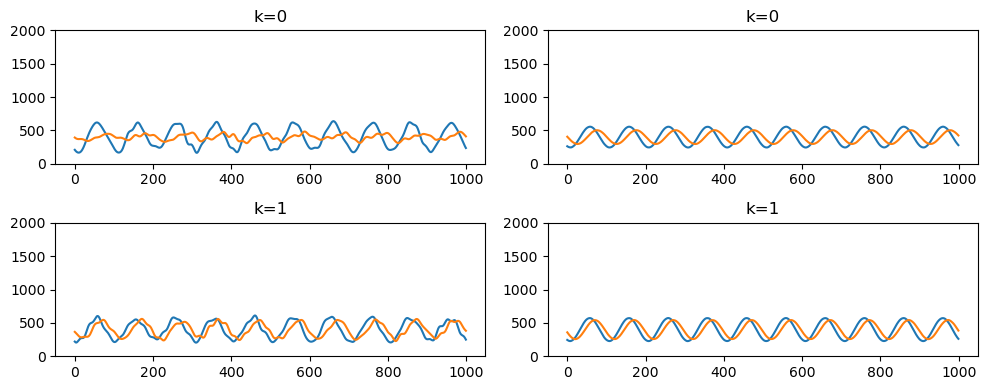

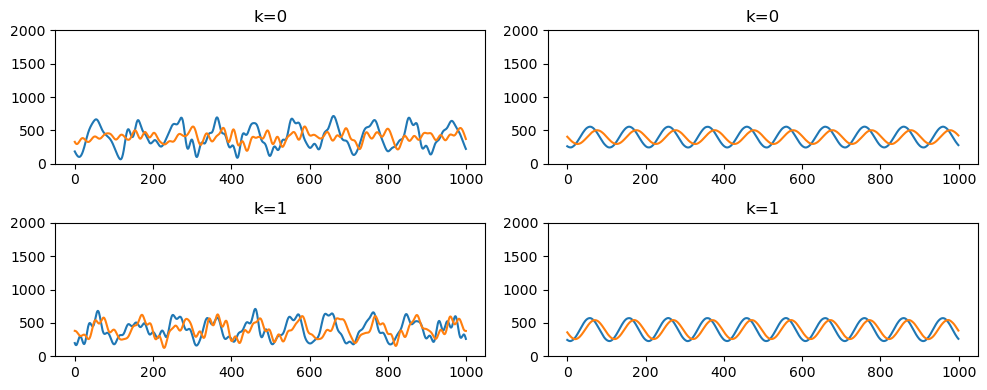

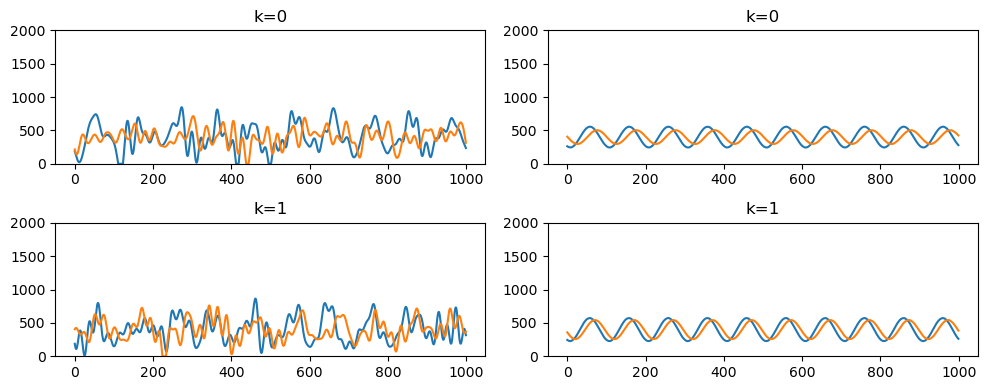

In [71]:
for r in range(5,10):
    fig,ax = plt.subplots(2,2,figsize=(10,4))
    mus_r = model_load['track'][0][r]['mus']

    vs = np.zeros((L,K,num_J_vars))
    for k in range(K):
        vs[:,k,:] = mus_r[:,k*num_J_vars:k*num_J_vars+num_J_vars]
    xs = np.einsum('ij,lkj->lki', Wv, vs)
    lams = cif_alpha_relu(alphas, xs)

    st = 20
    for l in range(st,st+2):
        ax[0,0].plot(lams[l,0,:])
        ax[0,0].set_title('k=0')
        ax[0,1].plot(lams_true[l,0,:])
        ax[0,1].set_title('k=0')
        ax[1,0].plot(lams[l,1,:])
        ax[1,0].set_title('k=1')
        ax[1,1].plot(lams_true[l,1,:])
        ax[1,1].set_title('k=1')
    ax[0,0].set_ylim([0,2000])
    ax[0,1].set_ylim([0,2000])
    ax[1,0].set_ylim([0,2000])
    ax[1,1].set_ylim([0,2000])
    plt.tight_layout()

In [388]:

lams.shape

(50, 2, 1000)

In [64]:
test2 = Q(gamma_r, gamma_r_inv, sig_r)

In [65]:
test2

-39983.65847554764

In [59]:
test1

(-39983.65847554764-5.669042849958495e-23j)

In [28]:
gamma_r.shape
gamma_r_inv = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])

In [46]:
# (np.trace(gamma_r_inv @ sig_r, axis1=2, axis2=3)).shape
quick_full = gamma_r_inv @ sig_r
quick_sum = np.trace(gamma_r_inv @ sig_r, axis1=2, axis2=3).sum()

In [45]:
res = np.zeros_like(sig_r)
sumB = 0
for l in range(L):
    for j in range(gamma_r.shape[0]):
        mult = gamma_r_inv[j,:,:] @ sig_r[l,j,:,:]
        res[l,j,:,:] = mult
        sumB += np.trace(mult)

### BFGS

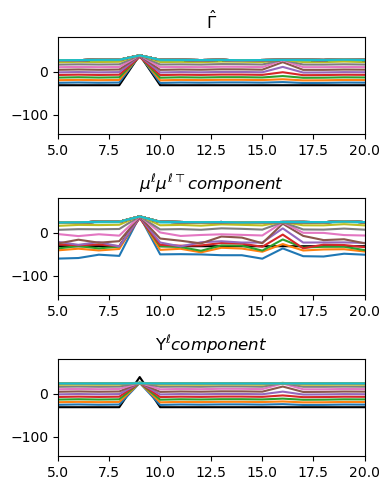

In [64]:
logS = True
delta = 1e-3
from cohlib.alg.em_sgc import get_freq_vecs_real
from cohlib.conv import conv_v_to_z
W = model_load['Wv']
num_J_vars = W.shape[1]
J = int(num_J_vars / 2)

Gamma_true = data_load['latent']['Gamma']
S_true = Gamma_true[:50,0,0].real
S_true = S_true*(delta**2*(2*np.pi)**2)
if logS is True:
    S_true = 10*np.log10(S_true)

Rs = [0, 4, 9, 14]
Rs = range(em_iters)

fig, ax = plt.subplots(3,1,figsize=(4,5))
ax[0].plot(S_true, 'k')
ax[1].plot(S_true, 'k')
ax[2].plot(S_true, 'k')

for r in Rs:
    mus = model_load['track'][0][r]['mus']
    Ups_invs = model_load['track'][0][r]['Ups_invs']

    Gamma_orig, Gamma_mu, Gamma_Upss = update_Gamma_complex_mod(mus, Ups_invs, K, num_J_vars)

    S_orig = Gamma_orig[:50,0,0].real
    S_orig = S_orig*(delta**2*(2*np.pi)**2)

    S_mu = Gamma_mu[:50,0,0].real
    S_mu = S_mu*(delta**2*(2*np.pi)**2)

    S_Upss = Gamma_Upss[:50,0,0].real
    S_Upss = S_Upss*(delta**2*(2*np.pi)**2)

    # S_true = Gamma[:50,0,0].real
    # S_oracle = Gamma_zest[:50,0,0].real
    # S_init = Gamma_init[:50,0,0].real

    # S_true = S_true*(delta**2*(2*np.pi)**2)
    # S_oracle = S_oracle*(delta**2*(2*np.pi)**2)
    # S_init = S_init*(delta**2*(2*np.pi)**2)
    if logS is True:
        S_orig = 10*np.log10(S_orig)
        S_mu = 10*np.log10(S_mu)
        S_Upss = 10*np.log10(S_Upss)

        # S_true = 10*np.log10(S_true)
        # S_naive = 10*np.log10(S_naive)
        # S_oracle = 10*np.log10(S_oracle)

    ax[0].plot(S_orig)
    ax[0].set_title(r'$\hat{\Gamma}$')
    ax[1].plot(S_mu)
    ax[1].set_title(r'$\mu^{\ell} \mu^{\ell \top} component$')
    ax[2].plot(S_Upss)
    ax[2].set_title(r'$\Upsilon^{\ell} component$')
    ax[0].set_ylim([-145,80])
    ax[1].set_ylim([-145,80])
    ax[2].set_ylim([-145,80])
    ax[0].set_xlim([5,20])
    ax[1].set_xlim([5,20])
    ax[2].set_xlim([5,20])
    plt.tight_layout()


### Newton

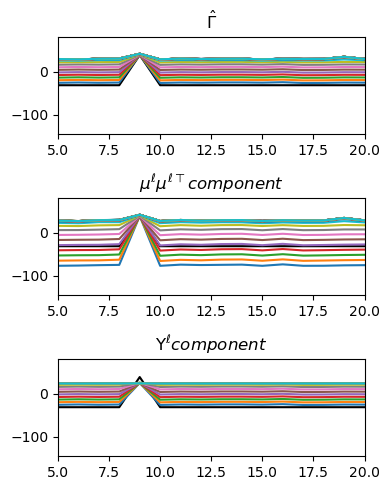

In [ ]:
logS = True
delta = 1e-3
from cohlib.alg.em_sgc import get_freq_vecs_real
from cohlib.conv import conv_v_to_z
W = model_load['Wv']
num_J_vars = W.shape[1]
J = int(num_J_vars / 2)

Gamma_true = data_load['latent']['Gamma']
S_true = Gamma_true[:50,0,0].real
S_true = S_true*(delta**2*(2*np.pi)**2)
if logS is True:
    S_true = 10*np.log10(S_true)

Rs = [0, 4, 9, 14]
Rs = range(em_iters)

fig, ax = plt.subplots(3,1,figsize=(4,5))
ax[0].plot(S_true, 'k')
ax[1].plot(S_true, 'k')
ax[2].plot(S_true, 'k')

for r in Rs:
    mus = model_load['track'][0][r]['mus']
    Ups_invs = model_load['track'][0][r]['Ups_invs']

    Gamma_orig, Gamma_mu, Gamma_Upss = update_Gamma_complex_mod(mus, Ups_invs, K, num_J_vars)

    S_orig = Gamma_orig[:50,0,0].real
    S_orig = S_orig*(delta**2*(2*np.pi)**2)

    S_mu = Gamma_mu[:50,0,0].real
    S_mu = S_mu*(delta**2*(2*np.pi)**2)

    S_Upss = Gamma_Upss[:50,0,0].real
    S_Upss = S_Upss*(delta**2*(2*np.pi)**2)

    # S_true = Gamma[:50,0,0].real
    # S_oracle = Gamma_zest[:50,0,0].real
    # S_init = Gamma_init[:50,0,0].real

    # S_true = S_true*(delta**2*(2*np.pi)**2)
    # S_oracle = S_oracle*(delta**2*(2*np.pi)**2)
    # S_init = S_init*(delta**2*(2*np.pi)**2)
    if logS is True:
        S_orig = 10*np.log10(S_orig)
        S_mu = 10*np.log10(S_mu)
        S_Upss = 10*np.log10(S_Upss)

        # S_true = 10*np.log10(S_true)
        # S_naive = 10*np.log10(S_naive)
        # S_oracle = 10*np.log10(S_oracle)

    ax[0].plot(S_orig)
    ax[0].set_title(r'$\hat{\Gamma}$')
    ax[1].plot(S_mu)
    ax[1].set_title(r'$\mu^{\ell} \mu^{\ell \top} component$')
    ax[2].plot(S_Upss)
    ax[2].set_title(r'$\Upsilon^{\ell} component$')
    ax[0].set_ylim([-145,80])
    ax[1].set_ylim([-145,80])
    ax[2].set_ylim([-145,80])
    ax[0].set_xlim([5,20])
    ax[1].set_xlim([5,20])
    ax[2].set_xlim([5,20])
    plt.tight_layout()


In [ ]:
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [112]:
from cohlib.conv import conv_v_to_z
W = model_load['Wv']
num_J_vars = W.shape[1]

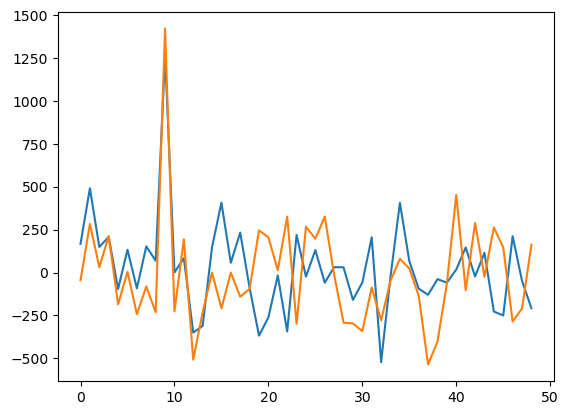

In [113]:
r = 19
k = 0
mus = model_load['track'][0][r]['mus']
mus.shape

mu_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
mu_zk = conv_v_to_z(mu_k, axis=1, dc=False)
plt.plot(np.real(mu_zk.mean(0)))
plt.plot(np.imag(mu_zk.mean(0)))
# plt.plot(np.abs(mu_zk.mean(0))**2)
# plt.plot(np.abs(mu_l))


In [114]:
mu_zk.shape

(50, 49)

In [115]:
mu_zk.shape

(50, 49)

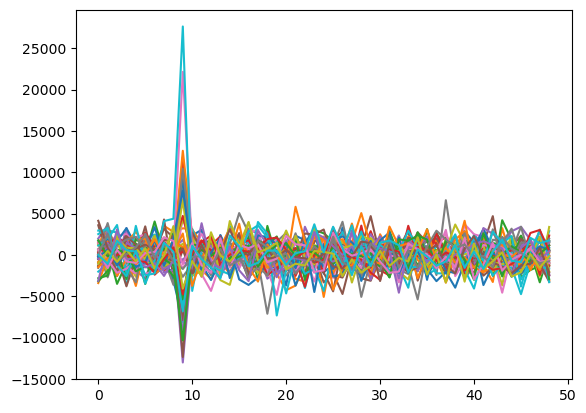

In [116]:
r = 19
k = 0
mus = model_load['track'][0][r]['mus']
mus.shape
for l in range(L):
    mu_l = mus[l,k*num_J_vars:k*num_J_vars+num_J_vars]
    mu_zl = conv_v_to_z(mu_l, axis=0, dc=False)
    plt.plot(np.real(mu_zl))
# plt.plot(np.abs(mu_l))


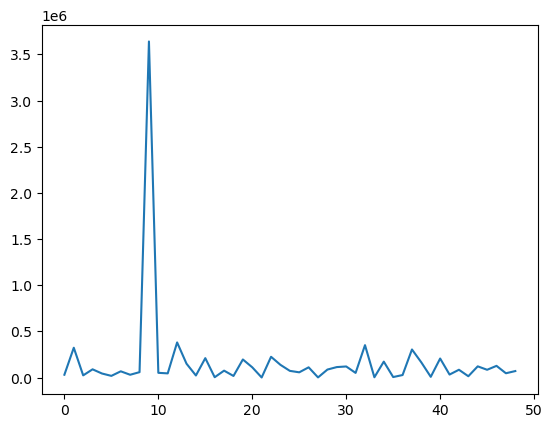

In [117]:
k = 0
mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
mus_k_mean = mus_k.mean(0)
mu_zk = conv_v_to_z(mus_k_mean, axis=0, dc=False)
plt.plot(np.abs(mu_zk)**2)

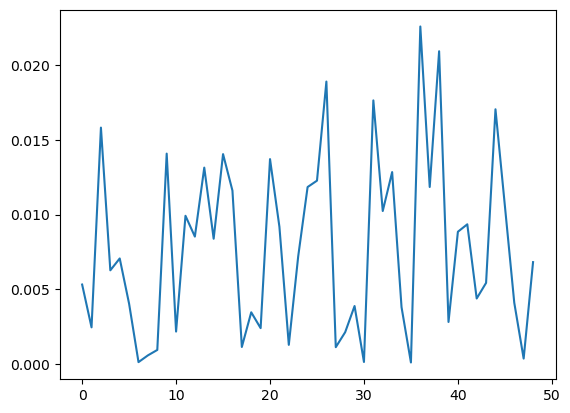

In [118]:
plt.plot(np.abs(mus_zk.mean(0))**2)

In [119]:
for i, r in enumerate(range(10, 15, -1)):
    print(4-i)

ping
ping


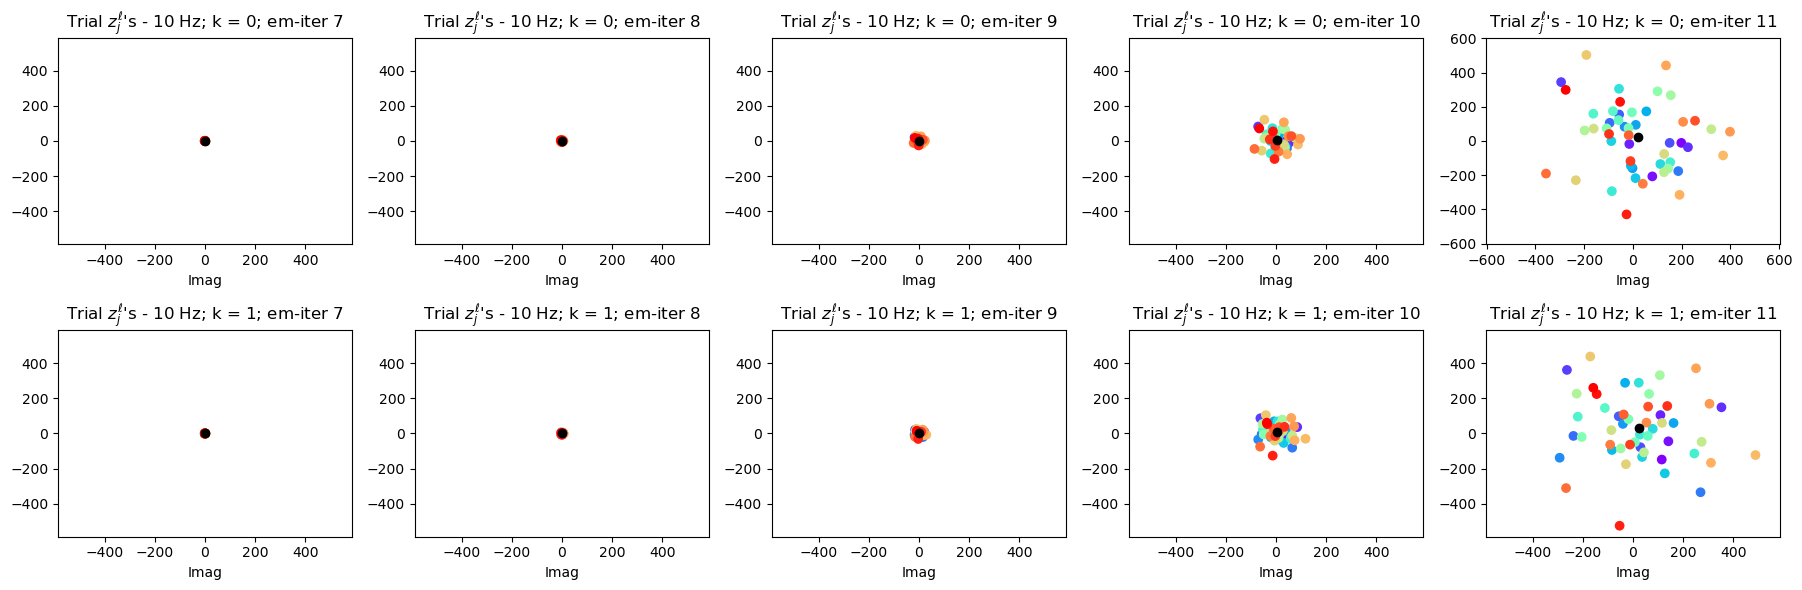

In [68]:
r = 19
k = 0
# for r in range(20):
#     mus = model_load['track'][0][r]['mus']
#     mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
#     # plt.plot(mus_zk.mean(0).real)
#     np.abs(mus_zk.mean(0))**2
#     plt.plot(np.abs(mus_zk.mean(0))**2)
j = 9
K = 2

stitr = 5
enditr = stitr+5

free_scale = False

fig, ax = plt.subplots(2,5,figsize=(18,6))
for i, r in enumerate(range(enditr, stitr, -1)):
    i = 4-i
    for k in range(K):
        mus = model_load['track'][0][r]['mus']
        mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
        mus_zk = conv_v_to_z(mus_k, axis=1, dc=False)
        color = plt.cm.rainbow(np.linspace(0, 1, L))

        ax[k,i].scatter(mus_zk[:,j].real, mus_zk[:,j].imag, c=color)
        ax[k,i].scatter(mus_zk[:,j].mean().real, mus_zk[:,j].mean().imag, c='k')
        # ak,x[i].set_title(r'$z_{j=5}$', f'; em-iter {r+1}')
        ax[k,i].set_title(f'Trial ' + r'$z_j^{\ell}$' + f'\'s - {j+1} Hz; k = {k}; em-iter {r+1}')
        ax[k,i].set_xlabel('Real')
        ax[k,i].set_xlabel('Imag')
        if i == 4:
            print('ping')
            lim = 1.2*np.max(np.concatenate([mus_zk[:,j].real, mus_zk[:,j].imag]))
        if free_scale is False:
            ax[k,i].set_xlim([-lim,lim])
            ax[k,i].set_ylim([-lim,lim])
plt.tight_layout()
plt.show()


# mus.shape
# for l in range(L):
#     mu_l = mus[l,k*num_J_vars:k*num_J_vars+num_J_vars]
#     mu_zl = conv_v_to_z(mu_l, axis=0, dc=False)
#     plt.plot(np.abs(mu_zl))

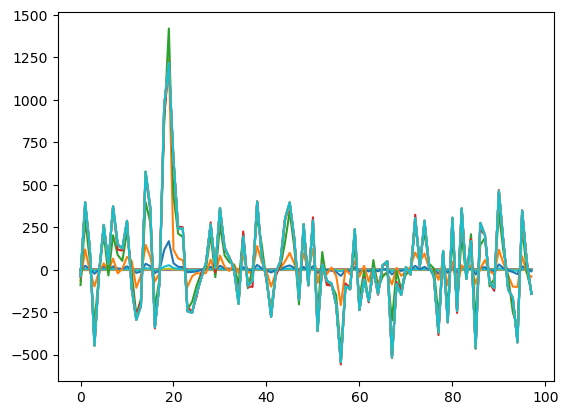

In [122]:
for r in range(20):
    mus = model_load['track'][0][r]['mus']
    mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
    mus_k_mean = mus_k.mean(0)
    plt.plot(mus_k_mean)

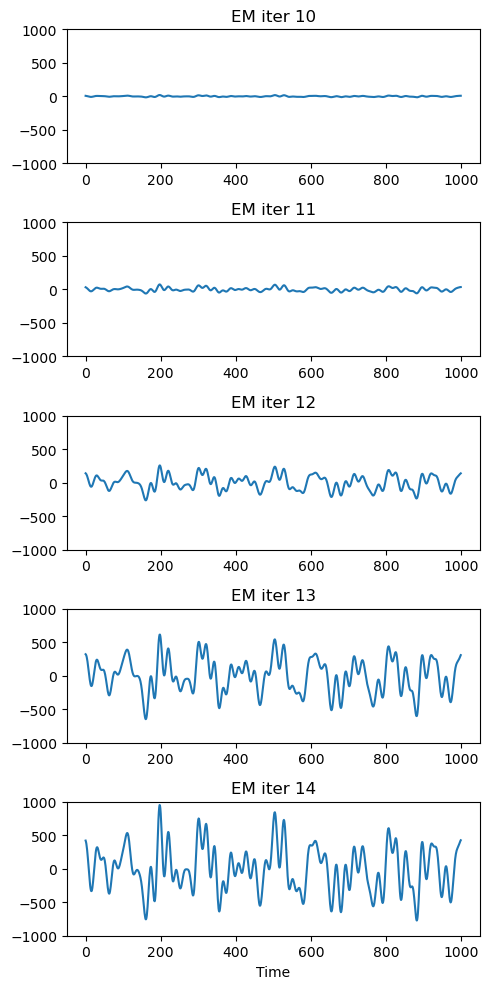

In [92]:
# for r in range(20):
l = 8
r = 15
fig, ax = plt.subplots(5,1,figsize=(5,10))
for i,r in enumerate(range(10,15)):
    mus = model_load['track'][0][r]['mus']
    mus_k = mus[:,k*num_J_vars:k*num_J_vars+num_J_vars]
    # for l in range(5):
    # x = alpha + W @ mus_k[l,:]
    x = W @ mus_k[l,:]
    ax[i].plot(x)
    ax[i].set_title(f'EM iter {r}')
    if i==4:
        ax[i].set_xlabel('Time')
    ax[i].set_ylim([-1000,1000])

plt.tight_layout()

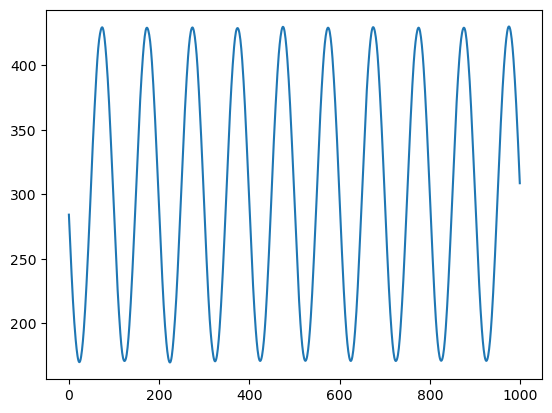

In [147]:
lams = model_load['lams']

plt.plot(lams[l,0,:])

350.0


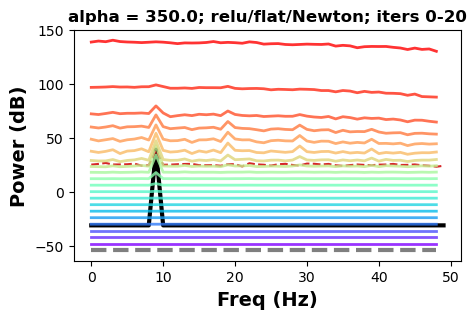

In [63]:
plot_res_S('relu', 'flat', 'Newton', 350.0, True, [0,20])

350.0


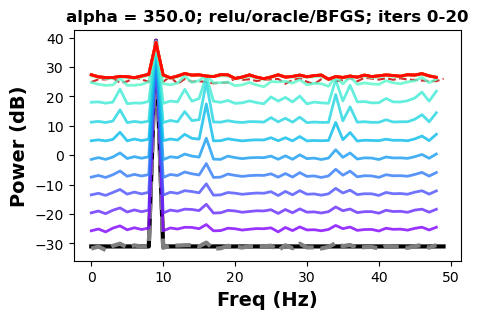

In [64]:
plot_res_S('relu', 'oracle', 'BFGS', 350.0, True, [0,20])

350.0


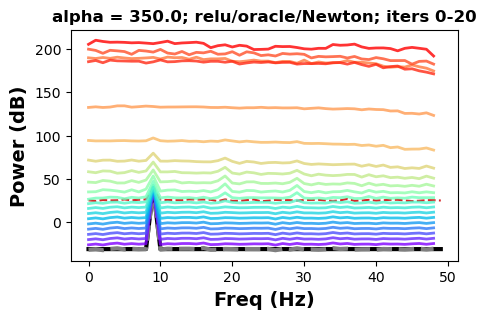

In [65]:
plot_res_S('relu', 'oracle', 'Newton', 350.0, True, [0,20])

50
50
50
50


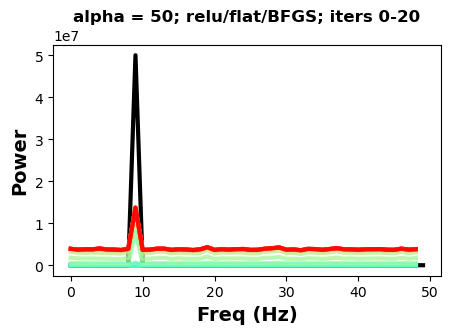

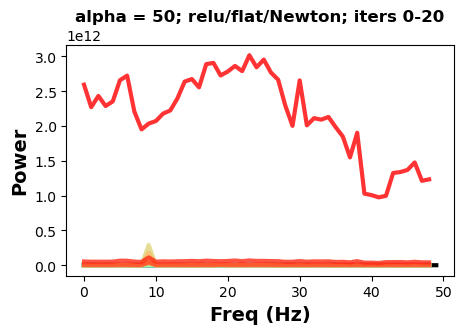

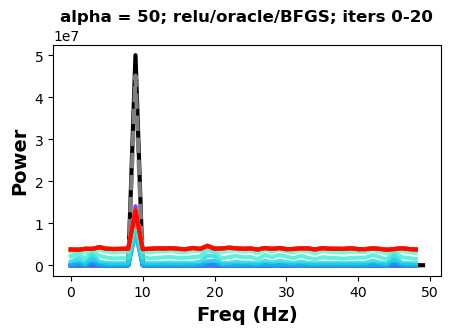

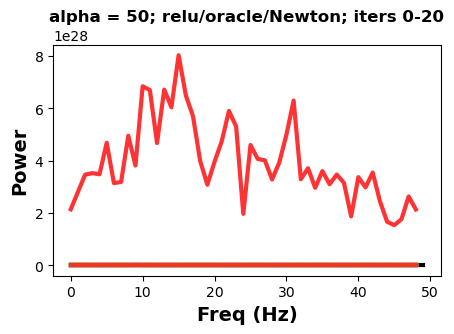

In [136]:
alpha = 50
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = False
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])

200
200
200
200
200
200
200
200


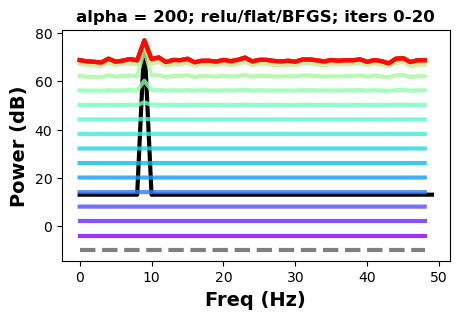

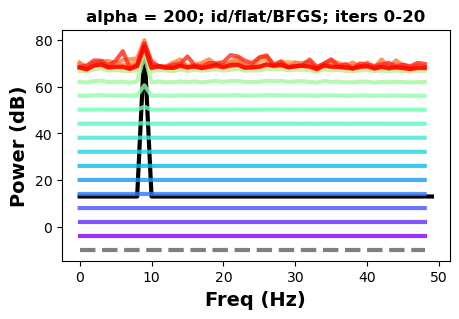

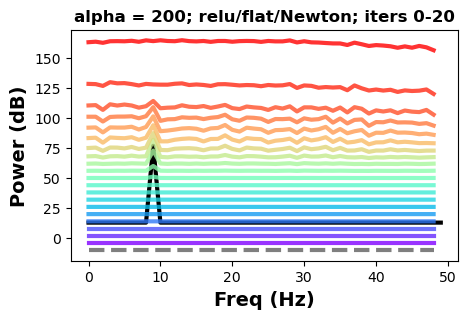

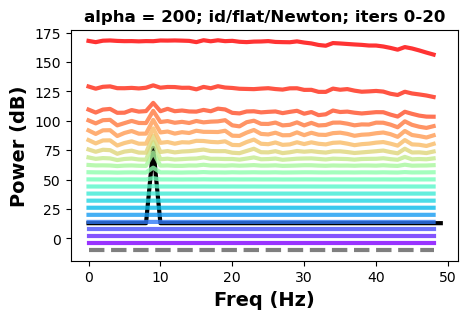

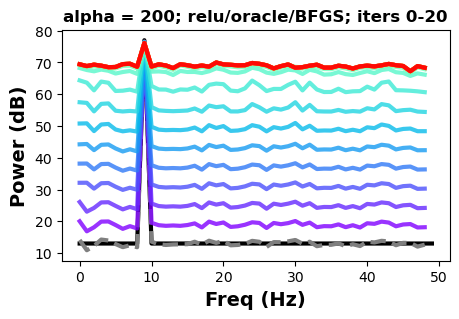

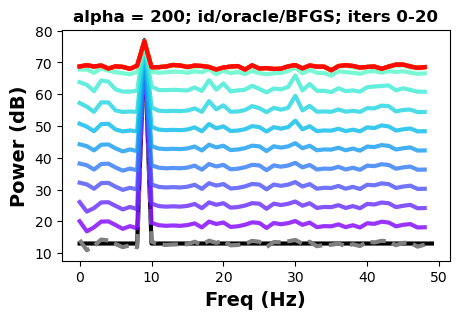

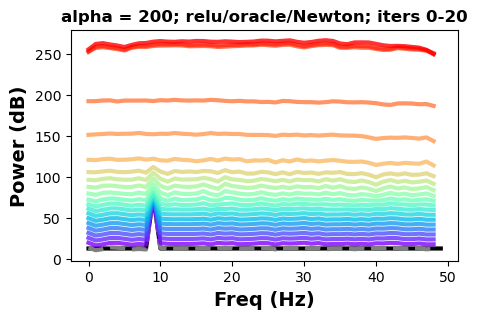

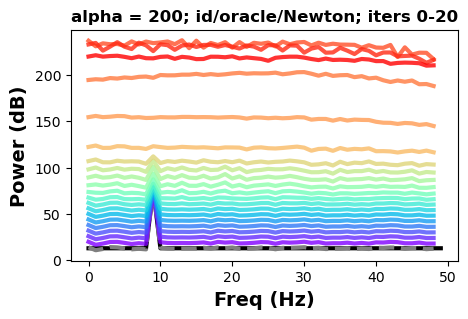

In [63]:
alpha = 200
for init_type in ["flat", "oracle"]:
    for optim_type in ["BFGS", "Newton"]:
        for link in ["relu", "id"]:
            fig, ax = plt.subplots(figsize=(5,3))
            i = 0

            track = np.array([0,20])
            track += 0



            print(alpha)
            logS = True
            alpha_dict = get_alpha_data(alpha, logS, link, init_type, optim_type, track=track)
            S_true = alpha_dict['S']['true']
            S_oracle = alpha_dict['S']['oracle']
            S_naive = alpha_dict['S']['naive']
            S_init = alpha_dict['S']['init']


            # coh_true = alpha_dict['coh']['true']
            # coh_oracle = alpha_dict['coh']['oracle']
            # coh_model = alpha_dict['coh']['model']
            # coh_naive = alpha_dict['coh']['naive']

            ax.plot(S_true, color='k', label='true', linewidth=3)
            ax.plot(S_init, '--', color='tab:grey', label='init', linewidth=3)
            # ax.plot(S_oracle, color='tab:green', label='direct')
            # ax.plot(S_naive, linestyle='--', color='tab:red', label='naive')


            if track is None:
                S_model = alpha_dict['S']['model']
                ax.plot(S_model, color='tab:blue', linewidth=3, label='model')
                ax.set_title(f'alpha = {alpha}', fontweight='bold', fontsize=14)
            else:
                S_model_list = alpha_dict['S']['model']
                color = plt.cm.rainbow(np.linspace(0, 1, len(S_model_list)))
                # for i, c in enumerate(color):
                # plt.plot(x, y, c=c)
                for e, c in enumerate(color): 
                    ax.plot(S_model_list[e], color=c, linewidth=3, alpha=0.8)
                ax.set_title(f'alpha = {alpha}; {link}/{init_type}/{optim_type}; iters {track[0]}-{track[1]}', fontweight='bold', fontsize=12)

            if logS is False:
                ax.set_ylabel(f'Power', fontweight='bold', fontsize=14)
            else:
                ax.set_ylabel(f'Power (dB)', fontweight='bold', fontsize=14)
            ax.set_xlabel('Freq (Hz)', fontweight='bold', fontsize=14)
            # if k == 3:
                # low = np.round(math.floor((1/Ks[k]) * 10)*(1/10),3)
                # ax[i1,i2].set_ylim([low, 1])
            # ax.set_ylim([1e4,1e8])